# Case - OEE

Copyright © 2019 Hsu Shih-Chieh

算法筆記：https://hackmd.io/@Annie/ByeX2_qtH (by Annie)

In [84]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
from datasets import load_oee
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
from collections import namedtuple
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from utils import set_font_cn
set_font_cn()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [4]:
data = load_oee() 
print(data.DESCR)

成型機案例數據
---------------------------

**Data Set Characteristics::**

    :控制器數據: 從控制器取出的螺桿位置, 油壓缸壓力, 料管溫度的數據統計值, 總共有44種數據
    
    :機台狀態燈號: 從控制器的機台狀態數據, 定義機台燈號
    
    :spccol_mapping: PLC數據欄位的中英文對照表
    


**讀取數據Sample Code**

::

    data= load_oee()


**Model Characteristics**
    
    :稼動率: 利用機台狀態燈號, 計算機台的工作時間比例
    
    :達成率: 實際完成模次/理想應完成模次
    
    :週期時間: 完成每一模次的時間



專案說明：
與TPM合作的Phase I, 透過控制器數據與機台狀態燈號, 實時計算稼動率, 達成率, 週期時間

..  image:: img/oee_main.jpg
    :height: 400
    :width: 400


### 稼動率

In [5]:
MID='A01'
light_Mid = data.ligutstatusdata[data.ligutstatusdata['machine_id']==MID]
Availability = namedtuple('Availability', 'start_dt, end_dt, availability')
start_dt = datetime(2019,10,11,8,0)
end_dt = datetime(2019,10,11,8,0)
availability_daylist=[]
for i in range(15):
    start_dt = end_dt
    end_dt = start_dt + timedelta(hours=24)
    light_day = light_Mid[(light_Mid['timestamp']>=start_dt.timestamp()) & (light_Mid['timestamp']<=end_dt.timestamp())]
    if len(light_day)==0:
        availability=0
    else:
        #計算每一個燈號持續的時間的時間
        light_day['delta']=light_day['timestamp'].diff(1)
        #計算稼動率
        delta=light_day['timestamp'].values[-1] - light_day['timestamp'].values[0]
        availability=np.round(light_day[(light_day['light_color']=='green')]['delta'].sum()/delta*100,3)
        
    avail = Availability(start_dt=start_dt, end_dt=end_dt, availability=availability)
    availability_daylist.append(avail)



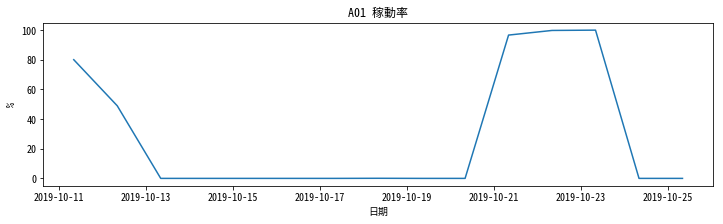

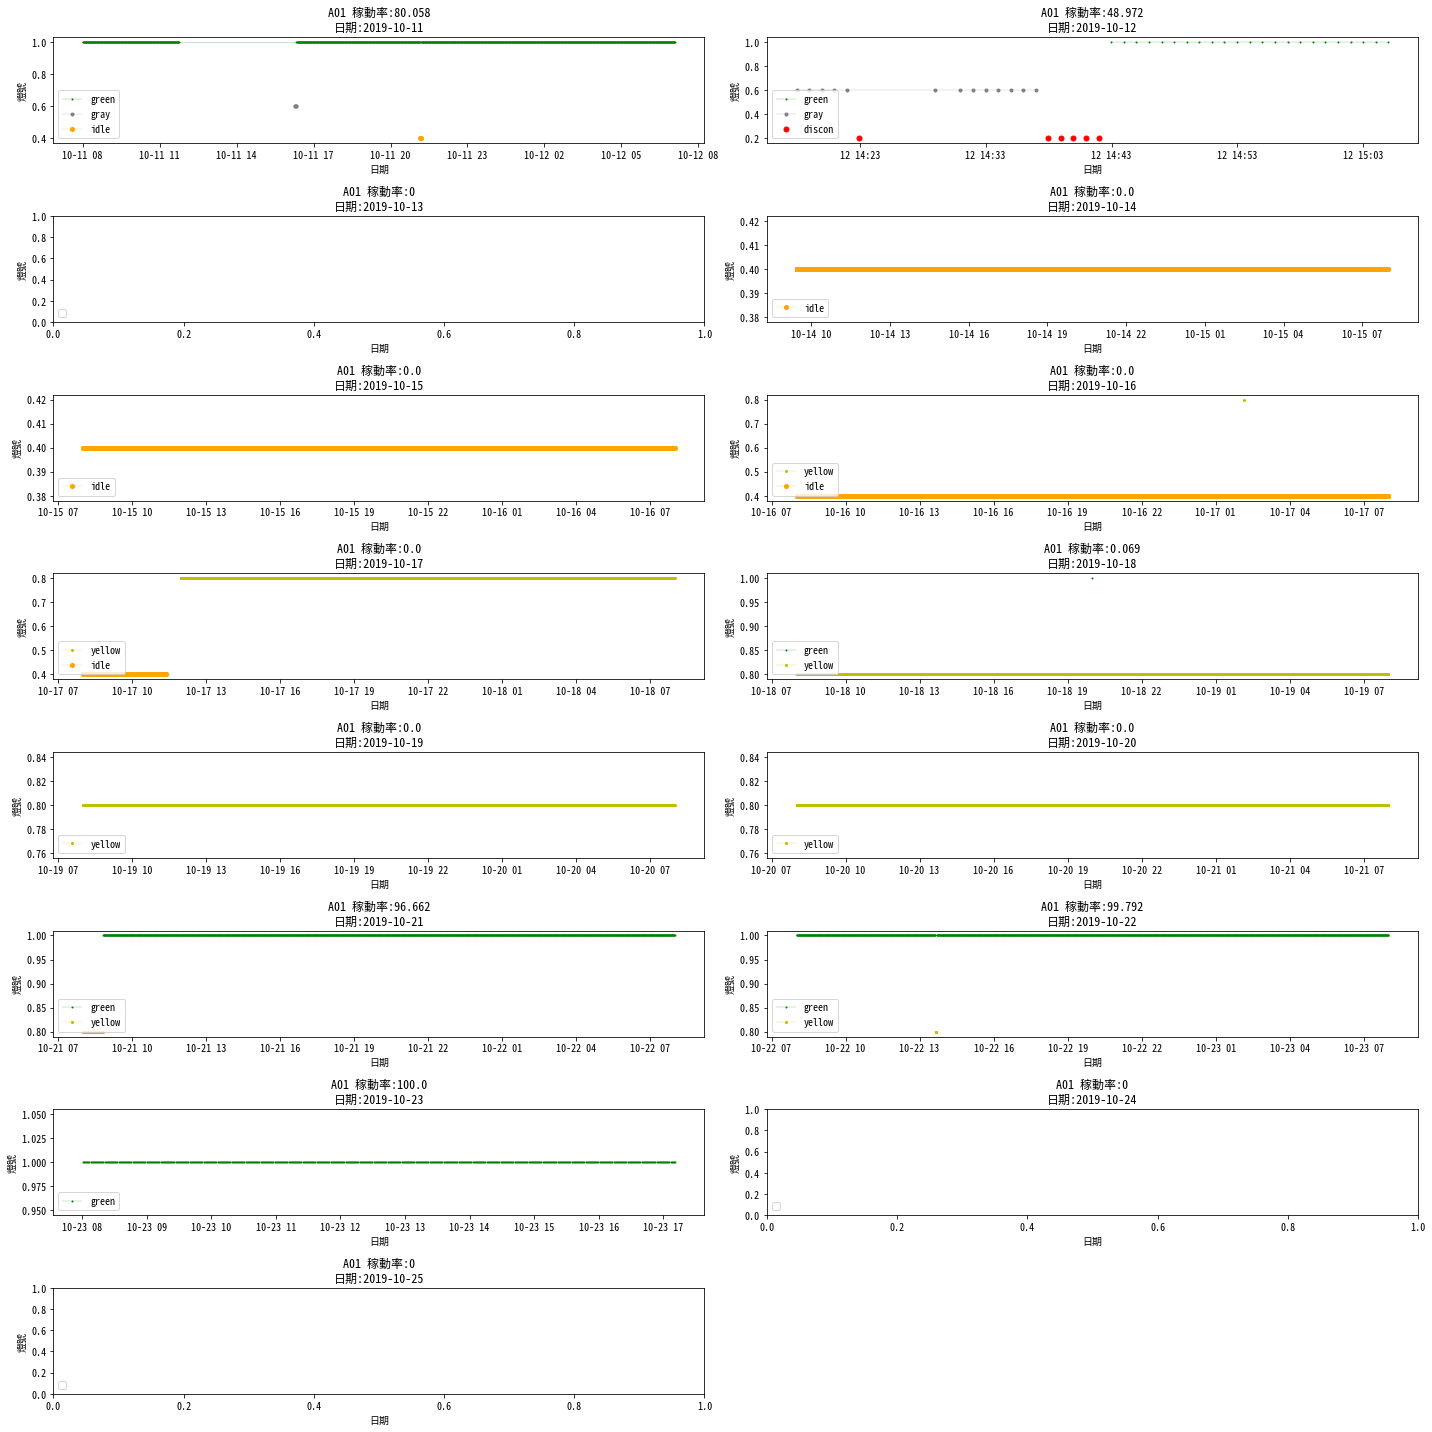

In [6]:
avail_days = list(map(lambda x: x.availability, availability_daylist))
dates = list(map(lambda x: x.start_dt, availability_daylist))
plt.figure(figsize=(12,3))
plt.plot(dates, avail_days)
plt.xlabel('日期')
plt.ylabel('%')
plt.title(f'{MID} 稼動率')
plt.show()
if True:
    plt.figure(figsize=(20,20))
    for i, avaobj in enumerate(availability_daylist):
        plt.subplot(8,2,1+i)
        light_day = light_Mid[(light_Mid['timestamp']>=avaobj.start_dt.timestamp()) & (light_Mid['timestamp']<=avaobj.end_dt.timestamp())]
        green = light_day[light_day['light_color']=='green']
        yellow = light_day[light_day['light_color']=='yellow']
        gray = light_day[light_day['light_color']=='gray']
        idle = light_day[light_day['light_color']=='icon_idle']
        icon_disconnected = light_day[light_day['light_color']=='icon_disconnected']
        if len(green)>0:
            plt.plot(green['dt'], [1]*len(green),'g.-', lw=0.2, ms=2, label='green')
        if len(yellow)>0:
            plt.plot(yellow['dt'], [0.8]*len(yellow),'y.-', lw=0.2, ms=4, label='yellow')
        if len(gray)>0:
            plt.plot(gray['dt'], [0.6]*len(gray),'.-', c='gray', lw=0.2, ms=6, label='gray')
        if len(idle)>0:
            plt.plot(idle['dt'], [0.4]*len(idle),'.-', c='orange', lw=0.2, ms=8, label='idle')
        if len(icon_disconnected)>0:
            plt.plot(icon_disconnected['dt'], [0.2]*len(icon_disconnected),'r.', lw=0.2, ms=10, label='discon')
            
        plt.legend(loc=3)
        plt.xlabel('日期')
        plt.ylabel('燈號')
        plt.title(f'{MID} 稼動率:{avaobj.availability}\n日期:{avaobj.start_dt.date()}')

    plt.tight_layout()
    plt.show()

### 達成率

In [7]:
ct_std={
    'A01':25.3,
    'A03':28,
    'A05':32,
    'A06':34,}    
yieldrate= 0.996


In [8]:
MID='A01'
spc_Mid = data.spcdata[data.spcdata['machine_id']==MID]

start_dt = datetime(2019,10,10,8,0)
end_dt = start_dt
achievelist_day =[]
for i in range(15):
    #
    start_dt = start_dt + timedelta(hours=24)
    end_dt = start_dt 
    Achieve = namedtuple('Achieve', 'start_dt, end_dt, achievingrate, achievingqty')
    achievelist=[]
    for i in range(48):
        end_dt = end_dt + timedelta(hours=0.5)
        spc_day = spc_Mid[(spc_Mid['timestamp']>=start_dt.timestamp()) & (spc_Mid['timestamp']<=end_dt.timestamp())]
        actual_num = np.floor(len(spc_day['SPC_0'].unique())*yieldrate)
        ## FIXME: 要改成真實的每日生產目標
        target_num = np.floor((end_dt-start_dt).total_seconds()/ct_std[MID])
        achievingrate = np.round(actual_num/target_num*100,3)
        ach = Achieve(start_dt=start_dt, end_dt=end_dt, achievingrate=achievingrate, achievingqty=spc_day.shape[0])
        achievelist.append(ach)
    achievelist_day.append(achievelist)


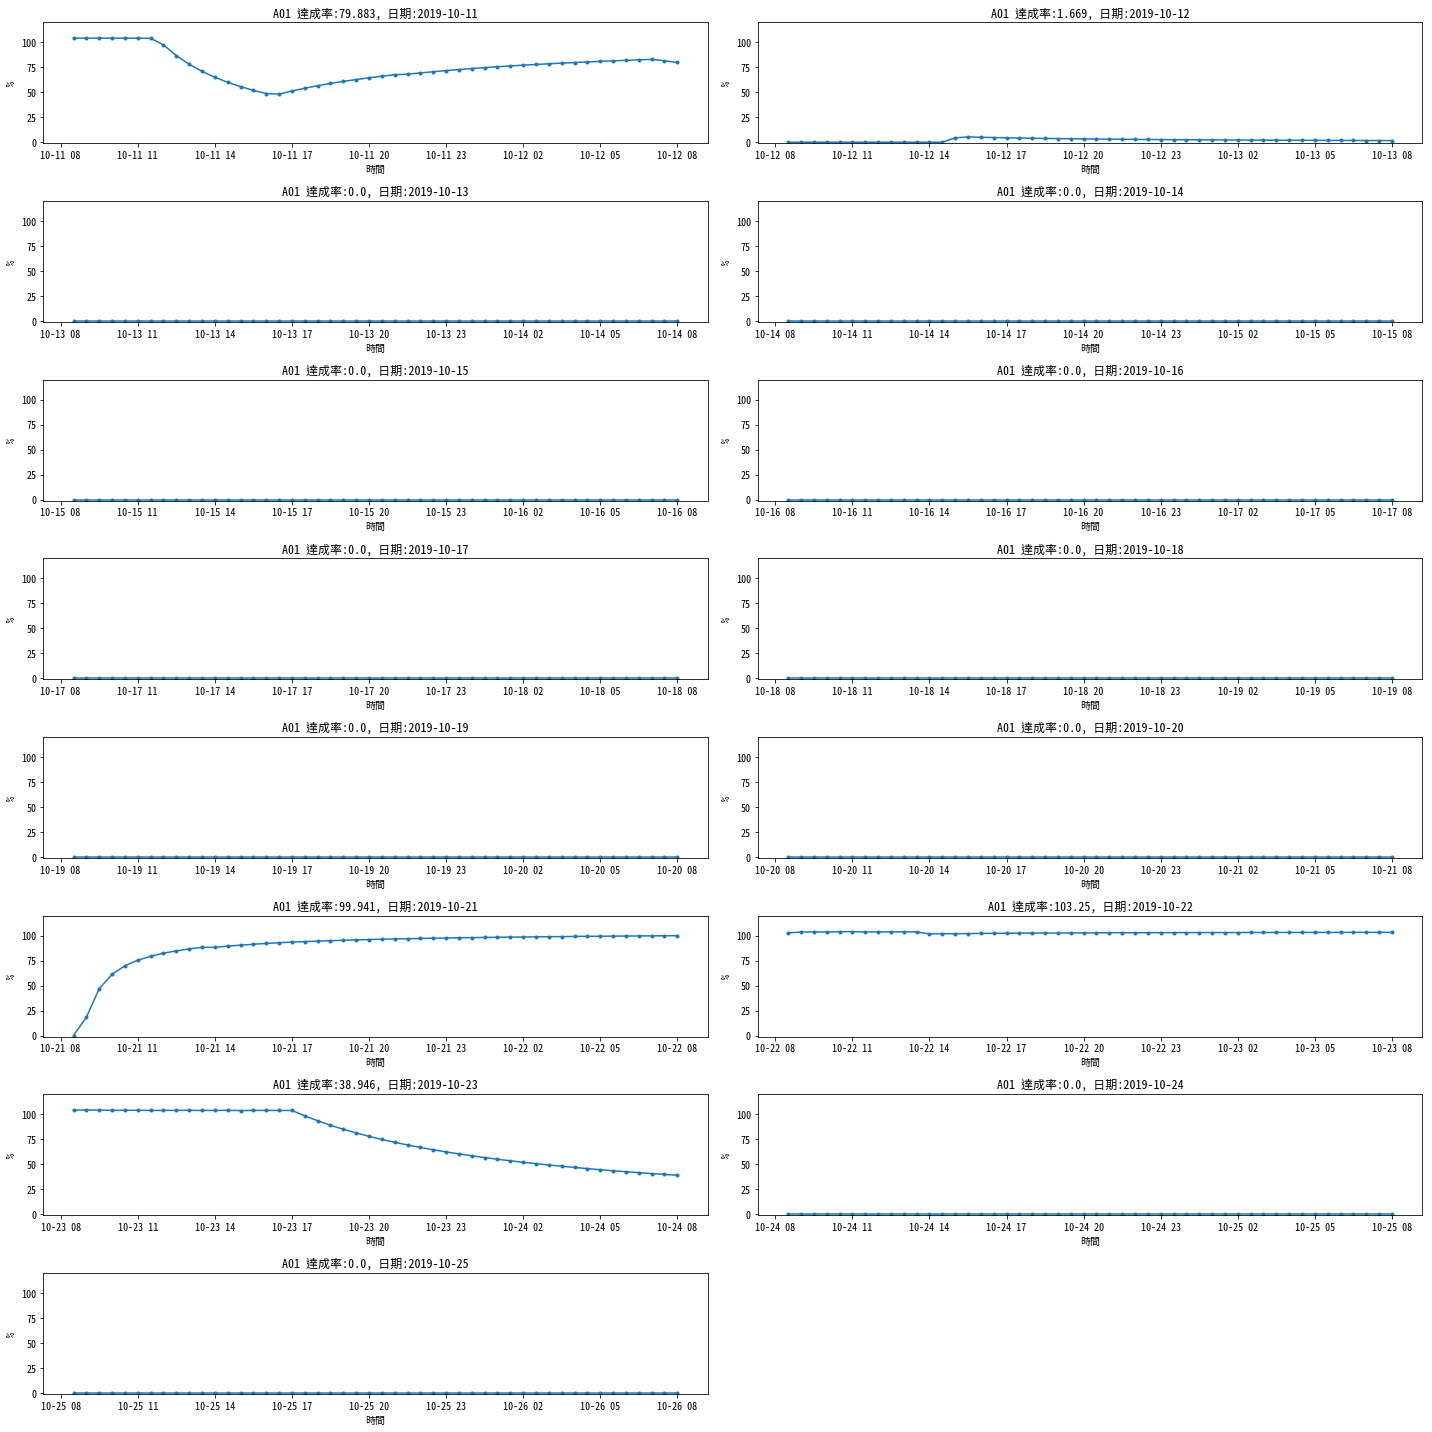

In [9]:
plt.figure(figsize=(20,20))
for i, achievelist in enumerate(achievelist_day):
    plt.subplot(8,2,1+i)
    achieverates = list(map(lambda x: x.achievingrate, achievelist))
    endtime = list(map(lambda x: x.end_dt, achievelist))
    plt.plot(endtime, achieverates, '.-')
    plt.xlabel('時間')
    plt.ylabel('%')
    plt.ylim(-1,120)
    plt.title(f'{MID} 達成率:{achieverates[-1]}, 日期:{endtime[0].date()}')
    
plt.tight_layout()
plt.show()    

### 週期時間

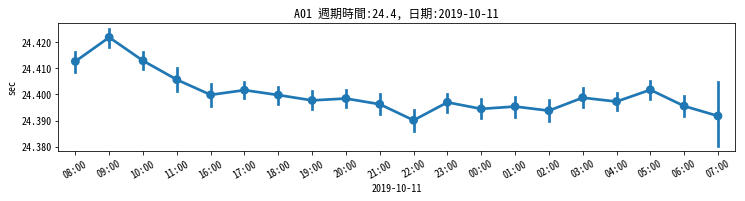

In [10]:
MID='A01'
spc_Mid = data.spcdata[data.spcdata['machine_id']==MID]

start_dt = datetime(2019,10,11,8,0)
end_dt = datetime(2019,10,11,8,0)

plt.figure(figsize=(20,20))
for i in range(1):
    plt.subplot(8,2,1+i)
    start_dt = end_dt
    end_dt = start_dt + timedelta(hours=24)
    spc_day = spc_Mid[(spc_Mid['timestamp']>=start_dt.timestamp()) & (spc_Mid['timestamp']<=end_dt.timestamp())]
    spc_day['60MIN'] = spc_day['dt'].map(lambda x: datetime(x.year, x.month, x.day, x.hour, 0 ))
    if len(spc_day)>0:
        ax = sns.pointplot(x='60MIN', y='SPC_9',  data=spc_day, estimator=np.nanmean, ci=95)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        ax.set_xticklabels([ label.split('T')[1].split('.')[0][:-3] for label in labels])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        d=labels[0].split('T')[0]
        t=np.round(spc_day['SPC_9'].mean(),1)
        plt.xlabel(d)
        plt.ylabel('sec')
        plt.xticks(rotation=30)
    else:
        t=0
    plt.title(f'{MID} 週期時間:{t}, 日期:{start_dt.date()}')        
        
plt.tight_layout()
plt.show()           

## 週期時間的進階分析
- Candle Stick (OCHL)
- 跳空缺口

In [141]:
import mpl_finance as mpf
from mpl_finance import candlestick_ohlc
from matplotlib.dates import date2num
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
from scipy import stats
import talib
import mpl_finance as mpf
from matplotlib.dates import MONDAY, DateFormatter, MonthLocator, HourLocator, WeekdayLocator, date2num

MID='A01'
start_dt = datetime(2019,10,11,8,0)
end_dt = datetime(2019,10,12,8,0)
spc_day = data.spcdata[(data.spcdata['machine_id']==MID) & (spc_Mid['timestamp']>=start_dt.timestamp()) & (spc_Mid['timestamp']<=end_dt.timestamp())]

if 'dt' in spc_day :
    spc_day.set_index('dt', inplace=True)



### Candle Stick (OCHL)
* Open: 時間區段開始時的ct
* Close: 時間區段結束時的ct
* High: 最高
* Low: 最低


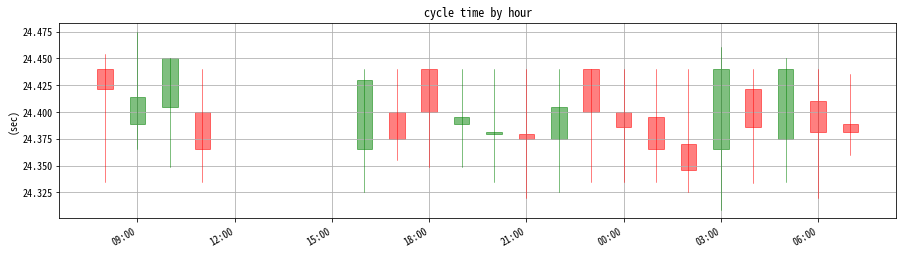

In [148]:
def plotcandlestick(data, rangeslider=True):
    fig = go.Figure(data=[go.Candlestick(x=data.index,
                    open=data['open'], high=data['high'], low=data['low'], close=data['close'],
                    increasing_line_color= 'red', decreasing_line_color= 'green')])
    fig.update_layout(title="cycle time by hour (plotly)", yaxis_title="(sec)", xaxis_rangeslider_visible=rangeslider)
    fig.show()

def plotcandlestick2(data):    
    quotes = zip(date2num(data.index.to_pydatetime()), data.open, data.close, data.low, data.high)
    fig, ax = plt.subplots(figsize=(15,4))
    mpf.candlestick_ochl(ax, quotes, width=0.02, colorup='r', colordown='g',alpha=0.5)
    daysFmt = DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(daysFmt)
    ax.autoscale_view()
    #ax.xaxis.grid(True, 'major')
    ax.xaxis.set_major_locator(HourLocator(byhour=range(0,24,3)))
    ax.grid(True)
    fig.autofmt_xdate()
    plt.ylabel('(sec)')
    plt.title('cycle time by hour (mpl_finance)')
    plt.show()    
    
    
ohlc_df = spc_day['SPC_9'].resample('60T').ohlc()
plotcandlestick(ohlc_df, False)
plotcandlestick2(ohlc_df)


### 跳空缺口
跳空缺口是指股價開盤價高於昨天的最高價或低於昨天的最低價, 使K線圖出現空檔的現象, 缺口的類型可以分為以下幾種
- 普通缺口: 價格很快被回補
- 突破缺口: 震盪
- 衰竭缺口: 沒有很快回補  
<br>
缺口的定義：
- 如果是上漲趨勢, 需要今天的最低價大於昨天收盤價格一個閥值以上
- 如果是下跌趨勢, 需要今天的最高價低於昨天收盤價格一個閥值以上  
<br>
閥值: 統計週期內收盤價格的中位數乘以3%


In [13]:

def judge_jump(today):
    assert 'preclose' in today
    global jump_pd
    jump=0
    jumppower=0
    #print(today.low-today.preclose, jump_threshold, (today.low - today.preclose) > jump_threshold)
    if (today.low - today.preclose) > jump_threshold:
        jump=1
        jumppower=(today.low-today.preclose)/jump_threshold
    elif today.preclose - today.high > jump_threshold:
        jump=-1
        jumppower=(today.preclose-today.high)/jump_threshold
    today['jump']=jump
    today['jump_power']=jumppower    
    return today

def plotcandlestick_jump(data, rangeslider=False):
    Candle = go.Candlestick(x=data.index,
                        open=data['open'], high=data['high'], low=data['low'], close=data['close'],
                        increasing_line_color= 'red', decreasing_line_color= 'green')
    
    jumpidx = np.where(jump_df["jump"]!=0)[0]
    Jump = go.Scatter(x= data.index[jumpidx],
                       y= data.iloc[jumpidx]["Marker"],
                       mode='markers',
                       name ='Jump',
                       marker=go.Marker(size=15,
                                        symbol=data.iloc[jumpidx]["Symbol"],
                                        color='orange')
                       )
    fig = go.Figure(data=[Candle, Jump])
    fig.update_layout(xaxis_rangeslider_visible=rangeslider)
    fig.show()
    

ohlc_df = spc_day['SPC_9'].resample('60T').ohlc()
print('1. 做一個跳空缺口')
tmp = ohlc_df.iloc[10]
ohlc_df.iloc[10] = tmp+0.8
plotcandlestick(ohlc_df, False)    
    
print('2. 根據上述規則找到跳空缺口\n   - 最低價大於昨天收盤價格一個閥值以上\n   - 最高價低於昨天收盤價格一個閥值以上')    
ohlc_df['preclose'] = ohlc_df['close'].shift(1)
ohlc_df['preclose'].fillna(method='bfill', inplace=True)
jump_threshold = ohlc_df.close.median()*0.03
print('\n跳空閥值:', jump_threshold)
jump_df = ohlc_df.apply(judge_jump, axis=1);
display(jump_df[jump_df['jump']!=0])
d=0.1
jump_df['Marker'] = np.where(jump_df["jump"]>0, jump_df["high"]+d, jump_df["low"]-d)
jump_df['Symbol'] = np.where(jump_df["jump"]>0, "triangle-up-open-dot", "triangle-down-open-dot")


plotcandlestick_jump(jump_df)    

1. 做一個跳空缺口


2. 根據上述規則找到跳空缺口
   - 最低價大於昨天收盤價格一個閥值以上
   - 最高價低於昨天收盤價格一個閥值以上

跳空閥值: 0.73176


,open,high,low,close,preclose,jump,jump_power
dt,,,,,,,
2019-10-11 18:00:00,25.200,25.24,25.149,25.240,24.40,1.0,1.023560
2019-10-11 19:00:00,24.395,24.44,24.349,24.389,25.24,-1.0,1.093255


/usr/local/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:441: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




### 黃金分割線
視覺上的黃金分割是指最小值與最大值之間的比例
- 視覺382: (最大值-最小值) x 0.382 + 最小值
- 視覺618: (最大值-最小值) x 0.618 + 最小值  
<br>
統計上的黃金分割: 按照序列值大小排序後, 取序列排序後對應位置上的值
- 統計382: 排序後排在38.2位置上的值
- 統計618: 排序後排在61.8位置上的值

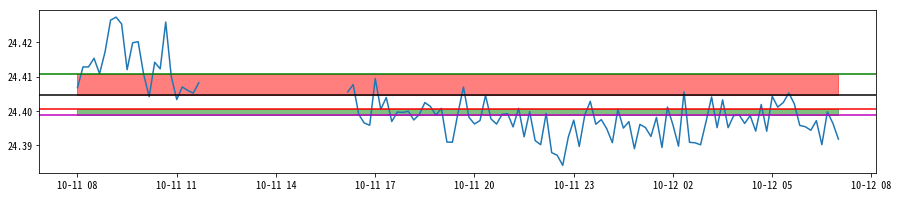

In [14]:
mean_df = spc_day['SPC_9'].resample('10T').mean()
sp382 = (mean_df.max() - mean_df.min())*0.382 + mean_df.min()
sp618 = (mean_df.max() - mean_df.min())*0.618 + mean_df.min()
sp382_stats = stats.scoreatpercentile(mean_df, 38.2)
sp618_stats = stats.scoreatpercentile(mean_df, 61.8)

above382 = max(sp382, sp382_stats)
below382 = min(sp382, sp382_stats)
above618 = max(sp618, sp618_stats)
below618 = min(sp618, sp618_stats)

plt.figure(figsize=(15,3))
plt.plot(mean_df)
plt.axhline(sp382, c='r')
plt.axhline(sp382_stats, c='m')
plt.axhline(sp618, c='g')
plt.axhline(sp618_stats, c='k')
plt.fill_between(mean_df.index, above618, below618, alpha=0.5, color='r')
plt.fill_between(mean_df.index, above382, below382, alpha=0.5, color='g')

### MACD
MACD稱為指數平滑異動移動平均線, 是從雙指數移動平均線發展而來的, 由快的指數移動平均線(EMA12)減去慢的指數移動平均線(EMA26)得到快線DIF, 再用2x(DIF - DEA(DIF的EMA9))的到MACD柱
- DIF小於零時表示目前趨勢往下(最近的股價低於歷史股價), DIF大於零時表示目前趨勢往上 (最近的股價高於歷史股價)
- DIF穿越零表示趨勢反轉
- MACD柱的數值表示趨勢變化程度, 數值變大表示趨勢程度加劇(最近的變化大於歷史變化), 數值變小表示趨勢程度放緩 (最近的變化小於歷史變化)
- MACD柱的數值表示趨勢方向, 紅色表示上漲, 綠色表示下跌

<br>
- TA-LIB安裝
    - brew install ta-lib
    - ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
    - pip install ta-lib


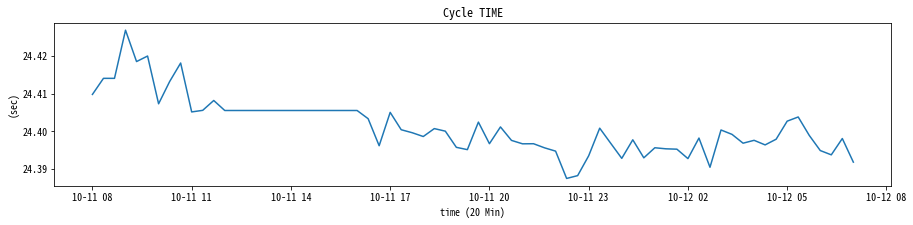

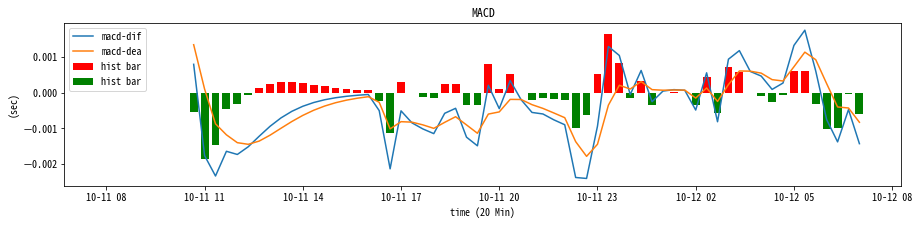

In [86]:
mean_df = spc_day['SPC_9'].resample('20T').mean()
mean_df.fillna(method='bfill', inplace=True)

plt.figure(figsize=(15,3))
plt.plot(mean_df)
plt.title('Cycle TIME')
plt.ylabel('(sec)')
plt.xlabel('time (20 Min)')


klindx = mean_df.index
dif, dea, bar = talib.MACD(mean_df.values, fastperiod=3,  slowperiod=6, signalperiod=4)

plt.figure(figsize=(15,3))
plt.plot(klindx, dif, label='macd-dif')
plt.plot(klindx, dea, label='macd-dea')
bar_red = np.where(bar>0, bar, 0)
bar_green = np.where(bar<0, bar, 0)
plt.bar(klindx, bar_red, 0.01, facecolor='red', label='hist bar')
plt.bar(klindx, bar_green, 0.01, facecolor='green', label='hist bar')
plt.title('MACD')
plt.ylabel('(sec)')
plt.xlabel('time (20 Min)')
plt.legend()


### ATR
- ATR, Average true range, 真實平均波動範圍, 主要用來衡量市場波動的強烈度, 顯示市場變化率的指標
- TR = Max( (最高價-最低價), (最高價-昨收), (昨收-最低價) )
- ATR = MA(TR, N), TR的N日簡單移動平均

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15b26e7b8>,
      dtype=object)

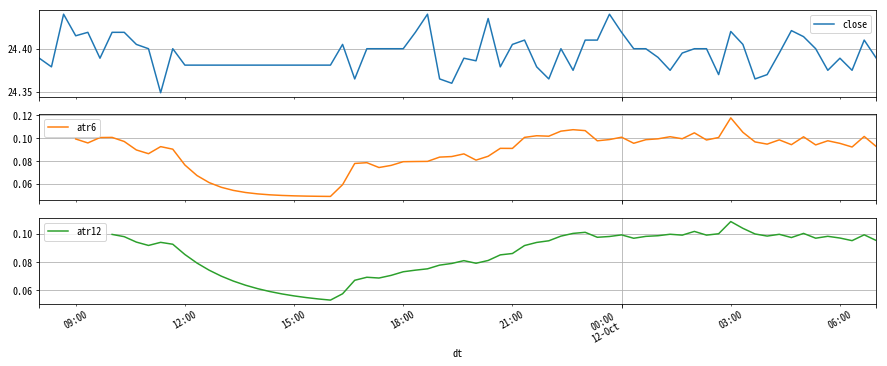

In [82]:
ohlc_df = spc_day['SPC_9'].resample('20T').ohlc()
ohlc_df.fillna(method='bfill', inplace=True)
atr6 = talib.ATR(ohlc_df.high.values, ohlc_df.low.values, ohlc_df.close.values, timeperiod=3)
atr12 = talib.ATR(ohlc_df.high.values, ohlc_df.low.values, ohlc_df.close.values, timeperiod=6)
#mean_df.fillna(method='bfill', inplace=True)
#plt.figure()
pd.DataFrame({'close':ohlc_df.close, 'atr6':atr6, 'atr12':atr12}).plot(subplots=True,grid=True, figsize=(15,6));
